In [1]:
from utils import *
import feature_extraction.ecgAutoencoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import pandas as pd

In [2]:
torch.cuda.is_available()

True

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


Epoch: 1, Cumulative Loss: 50.160692
Epoch: 2, Cumulative Loss: 34.217743
Epoch: 3, Cumulative Loss: 31.233153
Epoch: 4, Cumulative Loss: 26.506259
Epoch: 5, Cumulative Loss: 36.419953
Epoch: 6, Cumulative Loss: 30.182734
Epoch: 7, Cumulative Loss: 27.429675
Epoch: 8, Cumulative Loss: 21.916295
Epoch: 9, Cumulative Loss: 19.845489
Epoch: 10, Cumulative Loss: 21.198587
Epoch: 11, Cumulative Loss: 20.671539
Epoch: 12, Cumulative Loss: 18.911175
Epoch: 13, Cumulative Loss: 23.835966
Epoch: 14, Cumulative Loss: 26.381609
Epoch: 15, Cumulative Loss: 22.980164
Epoch: 16, Cumulative Loss: 22.299676
Epoch: 17, Cumulative Loss: 19.325793
Epoch: 18, Cumulative Loss: 22.245680
Epoch: 19, Cumulative Loss: 22.556752
Epoch: 20, Cumulative Loss: 21.755407
Epoch: 21, Cumulative Loss: 21.120143
Epoch: 22, Cumulative Loss: 21.388171
Epoch: 23, Cumulative Loss: 18.182864
Epoch: 24, Cumulative Loss: 17.476973
Epoch: 25, Cumulative Loss: 19.999272


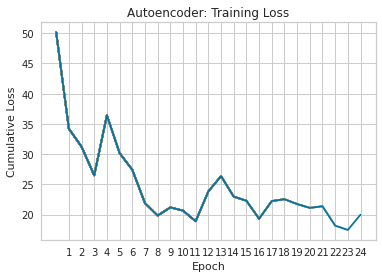

In [12]:
# Define your ECG dataset
class ECGDataset(Dataset):
    def __init__(self, ecgs):
        self.ecg = ecgs

    def __len__(self):
        return len(self.ecg)

    def __getitem__(self, index):
        return torch.tensor(self.ecg[index], dtype=torch.float32)


X, y, Y = label_ecgs(data_dir='/data/physionet/', sampling_rate=100)
labels = y.to_numpy()

# Test train split
X_train, X_test, labels_train, labels_test, Y_train, Y_test = train_test_split(X, labels, Y, test_size=0.2, random_state=33)


# Downsample the majority class

# Get indices of majority class (out of labels_train)
class_0_idx = np.where(labels_train == 0)[0]

# Get indices of minority class (out of labels_train)
class_1_idx = np.where(labels_train == 1)[0]

# Sample from majority class
unique, counts = np.unique(labels_train, return_counts=True)
count_dic = dict(zip(unique, counts))
n_samples = int(count_dic[1]*1.5)
sampled_class_0_idx = np.random.choice(class_0_idx, size=n_samples, replace=False)

# Merge the selected samples
idx_sampled = np.concatenate([sampled_class_0_idx, class_1_idx])
idx_sampled.sort()

# Filter train and labels_train
X_train = X_train[idx_sampled, :]
labels_train = labels_train[idx_sampled]
Y_train = Y_train.iloc[idx_sampled, :]

np.count_nonzero(labels_train == 0)
np.count_nonzero(labels_train == 1)

X_train.shape
labels_train.shape

# Create train and test data loaders
batch_size = 32
train_dataset = ECGDataset(X_train)
test_dataset = ECGDataset(X_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create the model
model = feature_extraction.ecgAutoencoder.ECGAutoencoder(input_shape=(1000, 12))

# Train the model
model.fit(train_dataloader, num_epochs=25, learning_rate=0.01)


# Save the model
torch.save(model.state_dict(), 'data/model_data/autoencoder100.pth')


In [13]:
train_ecgs = torch.stack([X.view(-1, 12*1000) for X in train_dataloader.dataset]).view(-1, 12*1000)

print(train_ecgs.shape)

# Get the latent space representation
with torch.no_grad():
    encoded_train = model.encoder(train_ecgs)

encoded_train.shape

encoded_train_df = pd.DataFrame(encoded_train.numpy())

# Save the latent space representation
#np.save('data/model_data/latent_space_train.npy', encoded_train_df)

torch.Size([7920, 12000])


In [14]:
test_ecgs = torch.stack([X.view(-1, 12*1000) for X in test_dataloader.dataset]).view(-1, 12*1000)

test_ecgs.shape

# Get the latent space representation
with torch.no_grad():
    encoded_test = model.encoder(test_ecgs)

encoded_test.shape

encoded_test_df = pd.DataFrame(encoded_test.numpy())

# Save the latent space representation
#np.save('data/model_data/latent_space_test.npy', encoded_test_df)

In [55]:
x_train = encoded_train_df
x_train['target'] = labels_train

x_test = encoded_test_df
x_test['target'] = labels_test

In [53]:
from pycaret.classification import *

exp_name = setup(
    data = x_train,
    target = 'target',
    fold_strategy='stratifiedkfold',
    test_data=x_test
)

,Description,Value
0,Session id,8415
1,Target,target
2,Target type,Binary
3,Original data shape,"(11520, 67)"
4,Transformed data shape,"(18720, 67)"
5,Transformed train set shape,"(11520, 67)"
6,Transformed test set shape,"(7200, 67)"
7,Numeric features,66
8,Rows with missing values,63.6%
9,Preprocess,True


In [54]:
best_model = compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.6555,0.5290,0.0148,0.6332,0.0288,0.0126,0.0523,0.3880
ridge,Ridge Classifier,0.6539,0.0000,0.0065,0.5681,0.0129,0.0045,0.0269,0.7460
dummy,Dummy Classifier,0.6536,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1680
lr,Logistic Regression,0.6532,0.5313,0.0048,0.4651,0.0094,0.0021,0.0130,1.3180
gbc,Gradient Boosting Classifier,0.6524,0.5254,0.0213,0.4569,0.0404,0.0105,0.0296,6.3160
ada,Ada Boost Classifier,0.6517,0.5257,0.0033,0.2883,0.0064,-0.0018,-0.0089,1.4960
lightgbm,Light Gradient Boosting Machine,0.6429,0.5082,0.0724,0.4161,0.1223,0.0218,0.0358,0.4020
nb,Naive Bayes,0.6304,0.5268,0.1647,0.4177,0.2341,0.0487,0.0585,0.5180
xgboost,Extreme Gradient Boosting,0.6270,0.5148,0.1128,0.3754,0.1729,0.0148,0.0198,3.4780
qda,Quadratic Discriminant Analysis,0.6194,0.5350,0.2233,0.4098,0.2887,0.0590,0.0641,0.5760


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [39]:
# Get the latent space representation
with torch.no_grad():
    decoded = model.decoder(encoded_train[0])

In [46]:
decoded_wave = decoded.detach().cpu().numpy()
first_lead = decoded_wave[0:1000]